# Recitation 03

These exercises will reinforce solution of general problems in chemical equilibrium for gas phase reactions at any temperature and pressure.  We will also cover how to handle non-ideality at high pressure.  We also introduce gaussian quadrature as a tool for solving definite integrals numerically.

**Topics Covered**

1. Formulation of gas-phase equilibrium problems at generic T, P, basis conditions.
2. Solution of algebraic equations using scipy.optimize
3. Building more complex functions to allow more general problem solutions
4. Gaussian quadrature in scipy.integrate
5. Fugacity coefficients
6. Using loops to solve equilibrium equations over a large (T,P) space.
7. Passing extra parameters using lambda functions.

In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import quadrature as quadgk
import matplotlib.pyplot as plt

**Problem 1**

In class, we have been considering the gas-phase reaction of molecular nitrogen with molecular hydrogen to produce ammonia:

$$N_2 (g) + 3H_2 (g) \leftrightarrow 2N\!H_3 (g)$$
	
We have specifically been solving for the equilibrium conversion of nitrogen and the equilibrium mixture composition at various temperatures and pressures.  In all examples, we have a stoichiometric (1:3) feed of $N_2$ to $H_2$, and we've assumed a basis of 1 mole of $N_2$, which means we also feed 3 moles of $H_2$ into the process.

Today, we're going to look at this problem in a general way and hopefully see that we can set it up using general functions where (T,P) are just parameters that we change.  Once we change them, we can re-solve the problem easily without changing any of our code. Generalizing solutions so that they work in any situation is one of the great things about programming, and it will help you to strengthen your understanding of how functions, root finding algorithms, and loops work in Python.

From class, recall that we have really no information about this reaction, and we want to figure out equilibrium compositions.  To do that, we need to learn more about the thermodynamics of the reaction, specifically the Gibbs free energy change of the reaction.  Once we have this, we can start to figure out composition.  As usual, we are basically considering the following equation, which relates the standard state Gibbs Free energy change to the composition at chemical equilibrum.

$$\exp\left(\frac{-\Delta G^\circ}{RT}\right) = K = \prod_{j = 1}^{N_S}a_j^{\nu_j}$$

**Reminder:** Let's specify standard states here.  We are going to be considering a generic reaction temperature, T, and a generic reaction pressure, P. For problems in chemical equilibrium, our standard state Gibbs free energy of reaction, $\Delta G^\circ$, is always specified at the reaction temperature, T, a pressure of 1 bar, and for a phase of matter dictated by the reaction as written.  Here, we are looking at a gas phase reaction.  For gases, we always use pure gases at 1 bar as our reference state. So:

**Reference State for ammonia synthesis reaction:** Pure gases at $T^\circ$ = Reaction Temperature, and $P^\circ$ = 1 bar.

Recall from class that we were able to look up the following data for $N_2$, $H_2$, and $N\!H_3$ as pure gases at 298K and 1 bar.

|Species | ${H_j}^\circ$ (kJ mol$^{-1}$)| ${S_j}^\circ$ (J mol$^{-1}$ K$^{-1}$) | ${C_{p_j}}^\circ$ (J mol$^{-1} $K$^{-1}$)|
|-------------|:-----------------------:|:-------------------------------------:|:-----------------------------------------|
| $N_2$ (g)   | 0                       |191.60                                 |29.12                                     | 
| $H_2$ (g)   | 0                       |130.68                                 |28.84                                     | 
| $N\!H_3$ (g)| -45.9                   |192.77                                 |35.64                                     |

This information is all we need to calculate the following:

* $\Delta H$ at any temperature, i.e. $\Delta H(T)$
* $\Delta S$ at any temperature, i.e. $\Delta S(T)$
* $\Delta G$ at any temperature, i.e. $\Delta G(T)$
* $K$ at any temperature, i.e. $K(T)$

We already did this in class, so I'm just going to copy the code below for K(T).  We then plot to illustrate that this function basically gives us K at any T of interest.  This is important because it gives us the left hand side of that equilibrium equation at any temperature!!

**Important:** The equilibrium constant, $K$, is a function only of temperature for a given reaction. It does not depend on pressure or the starting composition of the mixture. We account for these in the definitions of thermodynamic activities. Ultimately, the effect of temperature on a chemical equilibrium problem is fully described by the value of $K$, whereas pressure and composition effects are described by the values of thermodynamic activities, $a_j$.

In [2]:
def K(T):
    T0 = 298   #K
    R  = 8.314 #J/mol/K
    
    #Enthalpies at 298K, 1 bar
    HN0 = 0
    HH0 = 0
    HA0 = -45.9*1000 #J/mol

    #Entropies at 298K, 1 bar
    SN0 = 191.60 #J/mol/K
    SH0 = 130.68 #J/mol/K
    SA0 = 192.77 #J/mol/K

    #Heat capacities
    CPN = 29.12 #J/mol/K
    CPH = 28.84 #J/mol/K
    CPA = 35.64 #J/mol/K

    #Calculate thermodynamic state functions at T not equal to T0 = 298
    HN = HN0 + CPN*(T - T0) #J/mol
    HH = HH0 + CPH*(T - T0) #J/mol
    HA = HA0 + CPA*(T - T0) #J/mol

    SN = SN0 + CPN*np.log(T/T0) #J/mol/K
    SH = SH0 + CPH*np.log(T/T0) #J/mol/K
    SA = SA0 + CPA*np.log(T/T0) #J/mol/K

    DH = 2*HA - HN - 3*HH #J/mol
    DS = 2*SA - SN - 3*SH #J/mol/K
    DG = DH - T*DS        #J/mol

    K  = np.exp(-DG/R/T)     #Dimensionless
    return K

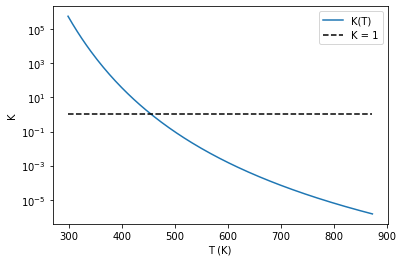

In [3]:
Tvals = np.linspace(298, 873, 200)
plt.plot(Tvals, K(Tvals), label = 'K(T)')
plt.hlines(1, 298, 873, linestyle = 'dashed', color = 'black', label = 'K = 1') #This is a reference line of K = 1
plt.yscale('log')
plt.ylabel('K')
plt.xlabel('T (K)')
plt.legend()

**Thermodynamic activities are where we describe composition and pressure effects**

Now that we have an equilibrum constant at any temperature done, we have to work on the right hand side of that equilbrium equation:

$$K = \prod_{j = 1}^{N_S}a_j^{\nu_j}$$

The thermodynamic activities are where our system/reference pressures and compositions come into play, so we need to specify them somehow. For gas phase reactions, regardless of temperature or operating pressure, we always do this the same way...so let's just imagine a general solution at *any* (T,P).

As we illustrated in class, if we expand the product operator, $\prod$, for ammonia synthesis, we find:

$$K = \frac{{a_{N\!H_3}}^{2}}{{a_{N_2}}{a_{H_2}}^3}$$

Regardless of the reaction temperature or pressure (or even phase of matter), we always define a thermodyanmic activity as:

$$a_j = \frac{\hat{f}_j}{f_j^\circ}$$

The numerator is the fugacity of species $j$ under reaction conditions $(T, P, \chi_j)$. 

The denominator is the fugacity of species $j$ in its reference state. Our reference state for gas-phase species is a pure species at 1 bar and the reaction temperature, T. Our convention for calculating fugacities of gases in a mixture uses the Lewis Randall rule.  As usual, this gives:

$$a_j = \frac{y_j \phi_j P}{y_j^\circ \phi_j^\circ  P^\circ}$$

Looking at the numerator, we are operating this reactor at an unknown pressure, P, so we aren't yet sure about the fugacity coefficient in the numerator, $\phi_j$. Looking at the denominator, the reference state is a pure species, so $y_j^\circ = 1$. Further, that pure species is at 1 bar, so $\phi_j^\circ = 1$

This gives a very general result for activities of gases in a mixture, where we retain the fugacity coefficient:

$$a_j = \frac{y_j \phi_j P}{P^\circ}$$

Notice that I'm still retaining $P$ and $P^\circ$ in my solution.  This helps me to keep it general, and to make sure that I take care to be dimensionally consistent.

You *can* make these substitutions.  There is noting wrong with developing the following equations, and they might help with illustrations...I just don't do this when I solve the problem in Python because the equations are messy to write and increase the chances I make mistakes.  

But, for completeness sake, just to make clear what shows up in the one "equation" we are trying to solve, you would get:

$$K = \frac{\left(\frac{y_{N\!H_3} \phi_{N\!H_3} P}{P^\circ}\right)^2}{\left(\frac{y_{N_2}\phi_{N_2}P}{P^\circ}\right) \left(\frac{y_{H_2}\phi_{H_2}P}{P^\circ}\right)^3}$$

We see multiple pressures and reference pressures that will cancel, giving:

$$K = \frac{{y_{N\!H_3}}^2}{y_{N_2}{y_{H_2}}^3} \frac{{\phi_{N\!H_3}}^2}{\phi_{N_2}{\phi_{H_2}}^3}\left(\frac{P^\circ}{P}\right)^2$$

This is a completely general equation that will apply at any Temperature or Pressure, so we can always use this result, regardless of the operating conditions.

As we discussed in class, $K$ is fully determined by the reaction temperature.  Once we set temperature, K is fixed no matter how much we change pressure or the starting composition.  Those things are important, but they all show up in the right hand side of the equation.  They do not impact the value of K.

This equation fully captures pressure effects.  Once we set the pressure, we see it appears in this equation (P).  It also changes the fugacity coefficients of each species.  Pressure dependencies do not appear anywhere else in the problem, so correctly specifiying our thermodynamic activities is how we account for changes in operating pressure.

**Using Stoichiometry to reduce unknowns**

Even after T is set (which gives us K) and pressure is set (which gives us P and all $\phi_j$ values), we still have 3 unknowns: the equilibrium mole fractions of all species ($y_{N_2}$, $y_{H_2}$, and $y_{N\!H_3}$). The final step before we can solve this equation is to define the mole fraction of each species as:

$$y_j = \frac{N_j}{N_{tot}} = \frac{N_j}{\sum N_j}$$

This allows us to define an extent of reaction, $\varepsilon$, and then specifiy the moles of each species as a function of extent using a "mole table" type of approach:

$$N_j = N_{j,0} + \nu_j \varepsilon$$

For simplicity, I will relabel the compounds using N (N$_2$), H (H$_2$), and A (NH$_3$) just for cleaner notation in the table below. 

$$N (g) + 3H (g) \leftrightharpoons 2A (g)$$

Applying this to each species, we find:

|Species   |In   |Change           |End                  |
|:---------|:---:|:---------------:|:-------------------:|
| N$_2$    |NN0  |-1$\varepsilon$  |NN0 - 1$\varepsilon$ | 
| H$_2$    |NH0  |-3$\varepsilon$  |NH0 - 3$\varepsilon$ |
| NH$_3$   |NA0  |+2$\varepsilon$  |NA0 + 2$\varepsilon$ |
| Total    |NT0  |-2$\varepsilon$  |NT0 - 2$\varepsilon$ |


Now that these are defined, we can substitute back into our mole fraction defintion:

$$y_j = \frac{N_j}{N_{tot}} = \frac{N_j}{\sum N_j}$$

So that everything back to thermodynamic activities is now defined as a function of only extent of reaction and pressure.  Once we specify pressure and temperature, we have only one unknown (the extent) and can solve the equilibrium problem.

For now, we'll make an incorrect assumption just to illustrate the basic problem before getting too fancy:  We will assume fugacity coefficients are always 1 no matter the operating pressure.

Notice that solving the problem when we have it formulated this way is just a matter of changing Trxn, Prxn, and maybe our initial guess:

In [4]:
def EQ4(ex):
    
    #Specifications for this problem
    T   = 298 #K
    P   = 1 #bar
    P0  = 1.0 #bar
    NN0 = 1.0 #moles
    NH0 = 3.0 #moles
    NA0 = 0.0 #moles
    
    #Mole Table, this captures extent of reaction
    NN  = NN0 - ex
    NH  = NH0 - 3*ex
    NA  = NA0 + 2*ex
    NT  = NN + NH + NA
    
    #Mole fractions -- note extent is built into definitions of NA, NB, NC, NT
    yN  = NN/NT
    yH  = NH/NT
    yA  = NA/NT
    
    #Fugacity coefficients -- generally species specific and a strong function of pressure
    phiN = 1
    phiH = 1
    phiA = 1
    
    #Activity definitions -- extents embedded in yA, yB, yC; P and P0 also show up.
    aN  = yN*phiN*P/P0
    aH  = yH*phiH*P/P0
    aA  = yA*phiA*P/P0
    
    #This is our ratio of thermodynamic activities at equiliribum, i.e., Kactivity = Product(a_j^nu_j)
    KACTIVITY = aA**2/aN/aH**3
    
    #And finall, our Thermodynamic equilibrium constant
    KTHERMO = K(T)
       
    return KACTIVITY - KTHERMO  #We want to find the value of extent where KCOMP - Kthermo = 0

In [5]:
ans, info = opt.newton(EQ4, 0.98, full_output = True) #This solves for the equilibrium extent

print(info, '\n') #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN0 = 1.0 #moles
NH0 = 3.0 #moles
NA0 = 0.0 #moles
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'Conversion of N2 is {round(XN,4)}, yN is {round(yN, 4)}, yH is {round(yH, 4)}, and yA is {round(yA, 4)}')

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 0.9678585932069598 

Conversion of N2 is 0.9679, yN is 0.0156, yH is 0.0467, and yA is 0.9377


**Equilibrium Problems 2, 3, or 4 can all be solved with the same function above....**

<span style="font-family:Times New Roman; font-size:2.0em;">**Equilibrium Example 5**</span>

**But what about nonideal gas behavior?  This is 200 bar after all**

True.  We really shouldn't set fugacity coefficients equal to 1, the problem is that they can be difficult to calculate. In general, you can calculate a fugacity coefficient using the following equation:

$$\ln(\phi_j) = \int_0^P\frac{\left(Z_j-1\right)}{P}d\!P$$

Or:

$$\phi_j = \exp\left(\int_0^P\frac{\left(Z_j-1\right)}{P}d\!P\right)$$

In this case, we have the following empirical functions that describe the compressibility factors for all gases at 600K.  These can be used to calculate fugacity coefficients.  Here, Pressures are in units of bar.

$$Z_{N_2} = 1 + 2.1735\times10^{-4}P + 6.2923\times10^{-7}P^2 - 2.3065\times10^{-10}P^3 - 3.0835\times10^{-14}P^4$$

$$Z_{H_2} = 1 + 4.3484\times10^{-4}P + 9.5380\times10^{-8}P^2 - 5.4028\times10^{-11}P^3 + 1.5314\times10^{-14}P^4$$

$$Z_{NH_3} = 0.99987 - 9.0961\times10^{-4}P - 1.0349\times10^{-6}P^2 + 2.6566\times10^{-9}P^3 + 4.6925\times10^{-12}P^4$$

Now, we need to use those to calculate fugacity coefficients at 200bar.  This is actually pretty easy to do in a programming language. We have polynomial expressions that give us compressibility factors for N$_2$, H$_2$, and NH$_3$ as a function of pressure, so all we need to do to calculate fugacity coefficients is integrate those gnarly looking polynomials...

You *could* do this by hand -- they are polynomials after all.  But I prefer to use gaussian quadrature (similar to what your calculator does to solve definite integrals).

**Gaussian Quadrature**

Before we deal with a complex looking function to handle fugacity coefficients, let's get a simple introduction to gaussian quadrature.  This is in the Scipy package, specifically as scipy.integrate.quadrature.  I've imported this as quadgk (Gauss-Kronrod quadrature) for simplicity. 

This basically works very similar to your graphing calculator does for solving a definitite integral. We define an integrand (the function we're integrating), and we specifiy the range of integration. For example, let's use it to solve the following definite integral using GK quadrature:

$$\int_0^{10} x^2 dx$$

We know that the solution to that integral is:

$$\frac{x^3}{3}\bigg |_0^{10} = 333.33$$

Now with quadgk (note we have to define the integrand as a function...):

In [6]:
example = lambda x: x**2
ans, error = quadgk(example, 0, 10)
print(ans)

333.33333333333326


With that in mind, we can use a similar approach to develop integrands as functions of pressure...

In [7]:
N2COEFFS  = [1.0000e+00, 2.1735e-04, 6.2923e-07, -2.3065e-10, -3.0835e-14]
H2COEFFS  = [1.0000e+00,  4.3484e-04,  9.5380e-08, -5.4028e-11,  1.5314e-14]
NH3COEFFS = [9.9987e-01, -9.0961e-04, -1.0349e-06,  2.6566e-09,  4.6925e-12]

**Step 1**: Write compressibility factors as functions of pressure.

Let's use lambda functions here. These are just univariate polynomias, so these can be easily written as a one linear.

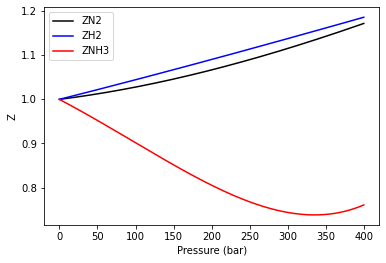

In [8]:
ZN  = lambda P: (1 + 2.1735e-4*P + 6.2923e-7*P**2 - 2.3065e-10*P**3 - 3.0835e-14*P**4)
ZH  = lambda P: (1 + 4.3484e-4*P + 9.5380e-8*P**2 - 5.4028e-11*P**3 + 1.5314e-14*P**4)
ZA  = lambda P: (0.99987 - 9.0961e-4*P - 1.0349e-6*P**2 + 2.6566e-9*P**3 + 4.6925e-12*P**4)
pplot = np.linspace(0,400,400) #We'll plot from 0 bar to 400 bar...
plt.plot(pplot, ZN(pplot), color = 'black', label = 'ZN2')
plt.plot(pplot, ZH(pplot), color = 'blue', label = 'ZH2')
plt.plot(pplot, ZA(pplot), color = 'red', label = 'ZNH3')
plt.xlabel('Pressure (bar)')
plt.ylabel('Z')
plt.legend()

Now that I have expressions for compressibility factors, I'll use them to define integrands that I can use to solve for the fugacity coefficients.  Again, we are trying to solve:

$$\phi_j = \exp\left(\int_0^P\frac{\left(Z_j-1\right)}{P}d\!P\right)$$

The integrand is the part I am integrating:

$$\phi_j = \exp\left(\int_0^P \textrm{integrand} \ d\!P\right)$$

So I'm now writing functions that define the integrands that I need to integrate to figure out the fugacity coefficients.

**Notice:** I am again using a lambda function since this is a nice, easy one liner.  I'm passing Pressure as a function argument, which then gets passed into Z(P).  Functions are neat this way---you can use a function inside of another function if it is useful to you!!

In [9]:
INTN  = lambda P: (ZN(P) - 1)/P
INTH  = lambda P: (ZH(P) - 1)/P
INTA  = lambda P: (ZA(P) - 1)/P

Now that I have the integrands defined, I can use Gaussian Quadrature to integrate them to any pressure I want. This is just integrating the integrand as a function of pressure from 0 to P.  Here, we'll use an upper limit of 200 bar since that is what the problem specifies for industrial synthesis of ammonia.

In [10]:
phiN = np.exp(quadgk(INTN, 0, 200)[0])
phiH = np.exp(quadgk(INTH, 0, 200)[0])
phiA = np.exp(quadgk(INTA, 0, 200, tol=1e-06, rtol=1e-06, maxiter=500)[0])
print(phiN, phiH, phiA)

1.056992064544399 1.0927939252498111 0.8226247909678744


Now, we're in a position to adapt our ammonia objective function to include fugacity coefficients.  

In [11]:
def EQ5(ex):
    #Specifications for this problem
    T   = 600 #K
    P   = 200 #bar
    P0  = 1.0 #bar
    NN0 = 1.0 #moles
    NH0 = 3.0 #moles
    NA0 = 0.0 #moles

    #Mole Table, this captures extent of reaction
    NN  = NN0 - ex
    NH  = NH0 - 3*ex
    NA  = NA0 + 2*ex
    NT  = NN + NH + NA
    
    #Mole fractions -- note extent is built into definitions of NA, NB, NC, NT
    yN  = NN/NT
    yH  = NH/NT
    yA  = NA/NT
    
    #Fugacity coefficients -- generally species specific and a strong function of pressure
    phiN = 1.057
    phiH = 1.093
    phiA = 0.823
    
    #Activity definitions -- extents embedded in yA, yB, yC; P and P0 also show up.
    aN  = yN*phiN*P/P0
    aH  = yH*phiH*P/P0
    aA  = yA*phiA*P/P0
    
    #This is our ratio of thermodynamic activities at equiliribum, i.e., Kactivity = Product(a_j^nu_j)
    KACTIVITY = aA**2/aN/aH**3
    
    #Our thermodynamic equilibrium constant
    KTHERMO = K(T)
       
    return KACTIVITY - KTHERMO  #We want to find the value of extent where KCOMP - Kthermo = 0

In [12]:
ans, info = opt.newton(EQ5, 0.98, full_output = True) #This solves for the equilibrium extent

print(info, '\n') #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN0 = 1.0 #moles
NH0 = 3.0 #moles
NA0 = 0.0 #moles
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'Conversion of N2 is {round(XN,4)}, yN is {round(yN, 4)}, yH is {round(yH, 4)}, and yA is {round(yA, 4)}')

      converged: True
           flag: 'converged'
 function_calls: 24
     iterations: 23
           root: 0.7466142677957369 

Conversion of N2 is 0.7466, yN is 0.1011, yH is 0.3032, and yA is 0.5957


**Now let's flex a little bit and really see if we can make this problem general**

There are a couple of things I don't like about the above approach.  The one we'll talk about now is that it requires me to basically re-write specifications and recalculate fugacity coefficients every time I change the temperature and the pressure.  What I would *like* to do is embed those calculations into my objective function so that I can just pass (T,P) as arguments and have the problem solve at any T,P that I like without me having to, e.g., hard-code values of the equilibrium constant or fugacity coefficients.  Let's start by moving everything inside of the function...and I'm going to give that function 3 arguments:  reaction extent, temperature, and pressure

In [13]:
def tempfun(ex, T, P):

    #Specifications for this problem
    #Trxn = T -- we are passing this into the function as an argument.
    #Prxn = P -- we are passing this into the function as an argument

    P0  = 1.0 #bar
    NN0 = 1.0 #moles
    NH0 = 3.0 #moles
    NA0 = 0.0 #moles
    
    #Mole Table, this captures extent of reaction
    NN  = NN0 - ex
    NH  = NH0 - 3*ex
    NA  = NA0 + 2*ex
    NT  = NN + NH + NA
    
    #Mole fractions -- note extent is built into definitions of NA, NB, NC, NT
    yN  = NN/NT
    yH  = NH/NT
    yA  = NA/NT
    
    #Fugacity coefficients -- generally species specific and a strong function of pressure; reuse integrand functions
    phiN = np.exp(quadgk(INTN, 0, P)[0])
    phiH = np.exp(quadgk(INTH, 0, P)[0])
    phiA = np.exp(quadgk(INTA, 0, P, tol=1e-06, rtol=1e-06, maxiter=500)[0])
    
    #Activity definitions -- extents embedded in yA, yB, yC; P and P0 also show up.
    aN  = yN*phiN*P/P0
    aH  = yH*phiH*P/P0
    aA  = yA*phiA*P/P0
    
    #This is our ratio of thermodynamic activities at equiliribum, i.e., Kactivity = Product(a_j^nu_j)
    KACTIVITY = aA**2/aN/aH**3
    
    #Calculate the equilibrium constant at T = Trxn
    KTHERMO = K(T) 
       
    return KACTIVITY - KTHERMO  #We want to find the value of extent where KCOMP - Kthermo = 0

Now we have a small problem -- we recall that for our equation solvers in scipy.optimize, they only really work on a function that takes one argument (our unknowns, ex in this case)...here, we need to give 3 arguments to our function (ex, T, P).  There are two ways to handle this in Python. I like the first one since it is the same as the way you'd do this in Matlab or in Julia, so it is general.  The second one is, as far as I know, Python-specific.

**Use a lambda function to pass extra parameters**

In [14]:
Trxn = 600 #K
Prxn  = 200 #bar
objective = lambda ex: tempfun(ex, Trxn, Prxn)
ans, info = opt.newton(objective, 0.95, full_output = True) #This solves for the equilibrium extent

print(info, '\n') #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN0 = 1.0 #moles
NH0 = 3.0 #moles
NA0 = 0.0 #moles
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'Conversion of N2 is {round(XN,4)}, yN is {round(yN, 4)}, yH is {round(yH, 4)}, and yA is {round(yA, 4)}')

      converged: True
           flag: 'converged'
 function_calls: 18
     iterations: 17
           root: 0.746634352937764 

Conversion of N2 is 0.7466, yN is 0.1011, yH is 0.3032, and yA is 0.5957


You can also pass them directly to opt.newton using the args keyword.  This is a pretty common option for both algebraic and ODE solvers in Python.  It is honestly pretty convenient, so it is worth knowing about.

**Using the args keyword argument**

In [15]:
Trxn = 600 #K
Prxn  = 200 #bar
ans, info = opt.newton(tempfun, 0.98, args = (Trxn, Prxn), full_output = True) #This solves for the equilibrium extent

print(info, '\n') #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN0 = 1.0 #moles
NH0 = 3.0 #moles
NA0 = 0.0 #moles
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'Conversion of N2 is {round(XN,4)}, yN is {round(yN, 4)}, yH is {round(yH, 4)}, and yA is {round(yA, 4)}')

      converged: True
           flag: 'converged'
 function_calls: 24
     iterations: 23
           root: 0.746634352937764 

Conversion of N2 is 0.7466, yN is 0.1011, yH is 0.3032, and yA is 0.5957


**How about making this really crazy and solving for a lot of temperatures and pressures with a loop?**

Perhaps it would be useful to map the equilibrium conversion in 3D space as a function of reaction temperature and reaction pressure.  We can easily do this!  One option is a for loop that will solve the objective function for a lot of temperatures and pressures.

In [16]:
P0  = 1.0 #bar
NN0 = 1.0 #moles
NH0 = 3.0 #moles
NA0 = 0.0 #moles

Tset = np.linspace(298, 873, 25)
Pset = np.linspace(1, 200, 30)
Xout = np.zeros((len(Tset), len(Pset)))

for i in range(0, len(Tset)):
    for j in range(0,len(Pset)):
        objective = lambda ex: tempfun(ex, Tset[i], Pset[j])
        ans, info = opt.brentq(objective, 1e-6, 0.99999, xtol = 1e-8, rtol = 1e-8, full_output = True)
        if info.converged == True:
            Xout[i,j] = ans/NN0
        if info.converged == False:
            print(info)

KeyboardInterrupt: 

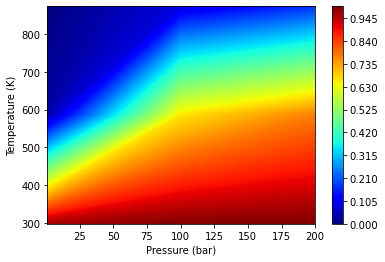

In [17]:
plt.contourf(Pset, Tset, Xout, levels = np.linspace(0, 1.0, 201), cmap = 'jet')
plt.xlabel('Pressure (bar)')
plt.ylabel('Temperature (K)')
plt.colorbar()